In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.stats import kendalltau

In [2]:
basepath = '/mnt/c/Users/guido/workcopies/apdft/t112/'
fns = glob.glob('%s/*/*/energies.csv' % basepath)

In [8]:
def read_file(fn):
    molid = fn.split('/')[-2]
    df = pd.read_csv(fn)
    df = df[~df.targets.str.contains('He')]
    df = df[~df.targets.str.contains('Li')]
    df['molid'] = molid
    lookup = {'HFsmall': 'HFs', 'HF': 'HF', 'CCSD2': 'CCSD'}
    df['method'] = lookup[fn.split('/')[8]]
    return df
qs = []
for fn in fns:
    q = read_file(fn)
    qs.append(q)
df = pd.concat(qs).reset_index()
df['hcount'] = df.targets.str.count('-')

In [11]:
# Goal: Gas-phase vertical deprotonation energies from APDFT
# apdft cheap, but efficient
### figure of one set of derivatives
# discuss shape for singly and doublz deprt
### accuracy APDFT
# systematic improvement with order
# HOT typically homogeneous and of decreasing variance (see accuracy figure)
# in apdft, this means that density responses are highly similar
# compare MAE to typical variance of depr E
# give median correction per order and proton count and method as table, discuss: simple correction per H
# describe suggested method: APDFT (cheap), correct from table, done
# practically relevant: how does ranking perform?
### figure ranking with order with HOT correction for singly and doubly separately, show kendall tau and rank1 accuracy
# can lower quality derivatives be used to go to higher order at decent cost?
### MAE and ranking CCSD + HF + HOT for orders 1-3 
# give numbers for relative computational cost
# as long as HF is reasonably good in describing the density (as often the case), the derivatives should work (here, we use a better basis set for HF, which helps numerics)

# decide later
# search for highest and lowest in QM9
# stretch: show relaxation can be captured with SQM



[0.01949809966597352, 0.04269136852193995]
[0.022459579559879206, 0.04077964533556361]


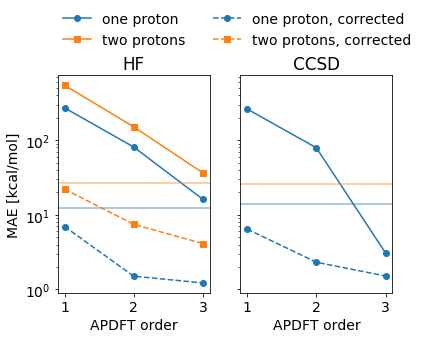

In [9]:
# TODO: second panel for CCSD
# show variances as shaded region
plt.rc('font', size=14)
f, axs = plt.subplots(1,2, sharex=True, sharey=True)

labels = ['one proton', 'two protons']

kcal =627.50947406
mediancorrection = {'HF': [], 'CCSD': []}
for midx,method in enumerate('HF CCSD'.split()):
    # get variance for comparison
    def get_s(hcount, method):
        stddevs = df.query("hcount == @hcount & method == @method").groupby('molid').std()['reference_energy'].values
        return np.average(stddevs[~np.isnan(stddevs)])
    stddevs = [get_s(_, method) for _ in (1, 2)]
    print (stddevs)
    
    for nh in (1, 2):
        s = df.query("hcount == @nh & method == @method")
        errors = []
        mediancorrected = []
        corr = []
        for order in (0, 1, 2):
            diff = s['total_energy_order%d' % order] - s.reference_energy
            errors.append(np.average(np.abs(diff)))
            corr.append(np.median(diff))
            mediancorrected.append(np.average(np.abs(diff - np.median(diff))))
        mediancorrection[method].append(corr)
        marker = '_os'[nh]
        axs[midx].semilogy(range(1, 4), np.array(errors)*kcal, '%s-' % marker, label=labels[nh-1], color='C%d' % (nh-1))
        axs[midx].semilogy(range(1, 4), np.array(mediancorrected)*kcal, '%s--' % marker, label="%s, corrected" % labels[nh-1], color='C%d' % (nh-1))
        axs[midx].axhline(stddevs[nh-1]*kcal, color='C%d' % (nh-1), alpha=0.5)

    legendorder = (0, 2, 1, 3)
    handles, labels = axs[midx].get_legend_handles_labels()
    handles = [handles[_] for _ in legendorder]
    labels = [labels[_] for _ in legendorder]
    
    axs[midx].set_xticks((1, 2, 3))
    if midx == 0:
        axs[midx].set_ylabel('MAE [kcal/mol]')
        axs[midx].legend(handles, labels, ncol=2, frameon=False, loc='upper left', bbox_to_anchor=(-0.05, 1.25, 0.1, 0.1))
    axs[midx].set_xlabel('APDFT order')
    axs[midx].set_title(method)

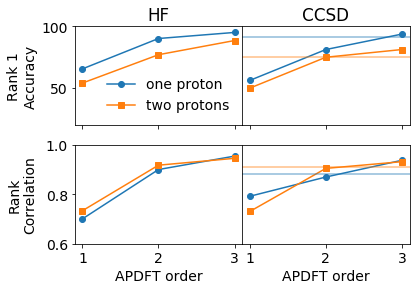

In [67]:
plt.rc('font', size=14)
f, axs = plt.subplots(2, 2, sharex=True, sharey=False)

# HF comparison against CCSD
HFdata = np.zeros((2,2))
HFcount = 0
for molid in df.molid.unique():
    for nh in (1, 2):
        sHF = df.query("method == 'HF' & molid == @molid & hcount == @nh").sort_values('targets')
        sCCSD = df.query("method == 'CCSD' & molid == @molid & hcount == @nh").sort_values('targets')
        if len(sHF) != len(sCCSD):
            continue
        actual = sHF['reference_energy'].rank(method='first').values
        expected = sCCSD['reference_energy'].rank(method='first').values
        if actual[expected == 1] == 1:
            HFdata[nh-1, 0] += 1
        if len(actual) == 1:
            kendall = 1
        else:
            kendall = kendalltau(actual, expected)[0]
        HFdata[nh-1, 1] += kendall
        HFcount += 1
HFdata = HFdata / HFcount * 2
for midx, method in enumerate('HF CCSD'.split()):
    tmediancorrection = np.array(mediancorrection[method])
    mergedmediancorrection = tmediancorrection[1]/2/2 + tmediancorrection[0]/2
    
    # nh, order, (rank1 correct,kendall tau)
    data = np.zeros((2,3,2))
    count = 0
    for nh in (1,2):
        s = df.query("hcount == @nh & method == @method")
        for molid, group in s.groupby('molid'):
            group = group.copy()
            for order in (0, 1, 2):
                count += 1
                mycol = 'total_energy_order%d' % order
                group[mycol] += mergedmediancorrection[order] * nh
                actual = group[mycol].rank(method='first').values
                expected = group['reference_energy'].rank(method='first').values
                if actual[expected == 1] == 1:
                    data[nh-1, order, 0] += 1
                if len(actual) == 1:
                    kendall = 1
                else:
                    kendall = kendalltau(actual, expected)[0]
                data[nh-1, order, 1] += kendall
    data = data/count*6
    
    # plot
    labels = ['one proton', 'two protons']
    markers = '_os'
    for nh in (1, 2):
        axs[0, midx].plot((1, 2, 3), data[nh-1, :, 0]*100, '%s-' % markers[nh], label= labels[nh-1])
        axs[1, midx].plot((1, 2, 3), data[nh-1, :, 1], '%s-' % markers[nh],label=labels[nh-1])
    axs[1, midx].set_xlabel('APDFT order')
    axs[1, midx].set_xticks((1, 2,3))
    axs[0, midx].set_title(method)
    axs[0, 0].set_ylabel('Rank 1\nAccuracy')
    #axs[1].set_xlabel('APDFT order')
    #axs[1].set_xticks((1, 2,3))
    axs[1, 0].set_ylabel('Rank\nCorrelation')
    #axs[0].legend(frameon=False)
    axs[0,0].legend(frameon=False,)#loc='upper left', bbox_to_anchor=(0.52, 1.5, 0,0))
    axs[0, midx].set_ylim(20, 100)
    axs[1, midx].set_ylim(0.6, 1)

# comparison to HF
for nh in (1,2):
    axs[0, 1].axhline(HFdata[nh-1, 0]*100, color='C%d' % (nh-1), alpha=0.5)
    axs[1, 1].axhline(HFdata[nh-1, 1], color='C%d' % (nh-1), alpha=0.5)

# layout
axs[0, 1].set_yticks([],[])
axs[1, 1].set_yticks([],[])
f.align_ylabels(axs)
f.subplots_adjust(wspace=0.0, hspace=0.2)

In [103]:
# CCSD 123           mae_ccsd_comp(1, True)
# CCSD 1 HF
# jeweils mit corr
import functools

@functools.lru_cache(maxsize=100)
def mae_ccsd_comp(nh, correction):
    s = df.query("hcount == @nh & method == 'CCSD'")
    errors = []
    mediancorrected = []
    corr = []
    for order in (0, 1, 2):
        diff = s['total_energy_order%d' % order] - s.reference_energy
        errors.append(np.average(np.abs(diff)))
        corr.append(np.median(diff))
        mediancorrected.append(np.average(np.abs(diff - np.median(diff))))
    mediancorrection[method].append(corr)
    marker = '_os'[nh]
    if correction:
        return np.array(mediancorrected)*kcal
    else:
        return np.array(errors)*kcal

@functools.lru_cache(maxsize=100)
def mae_ccsdhf_comp(nh, correction=False):
    ret = []
    for order in (0, 1, 2):
        mixed = []
        for molid in df.molid.unique():
            sHF = df.query("method == 'HF' & molid == @molid & hcount == @nh").sort_values('targets')
            sCCSD = df.query("method == 'CCSD' & molid == @molid & hcount == @nh").sort_values('targets')
            if len(sHF) != len(sCCSD):
                continue
            if order == 1: 
                mixenergies = sCCSD.total_energy_order0.values + sHF.total_energy_order1.values - sHF.total_energy_order0.values
            if order == 0:
                mixenergies = sCCSD.total_energy_order0.values
            if order == 2:
                mixenergies = sCCSD.total_energy_order0.values + sHF.total_energy_order2.values - sHF.total_energy_order0.values
            mixdiff = mixenergies - sCCSD.reference_energy.values
            if correction:
                mixdiff -= np.median(mixdiff)

            mixed += list(np.abs(mixdiff))
        ret.append(np.average(mixed)*kcal)
    return np.array(ret)

Text(0.5, 1.0, 'Two Protons')

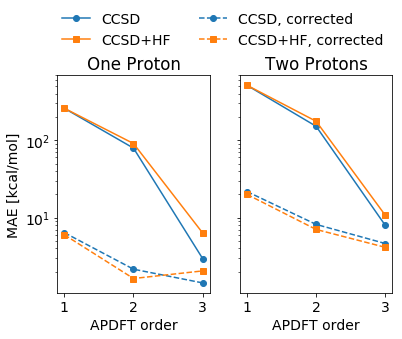

In [109]:
plt.rc('font', size=14)
f, axs = plt.subplots(1,2, sharex=True, sharey=True)

labels = ['one proton', 'two protons']
funcs = (mae_ccsd_comp, mae_ccsdhf_comp)
kcal =627.50947406
for midx,method in enumerate('CCSD CCSD+HF'.split()):
    # get variance for comparison
    for nh in (1, 2):
        vals = funcs[midx](nh, False)
        marker = '_os'[midx+1]
        axs[nh-1].semilogy(range(1, 4), np.array(vals), '%s-' % marker, label=method, color='C%d' % (midx))
        
        vals = funcs[midx](nh, True)
        axs[nh-1].semilogy(range(1, 4), np.array(vals), '%s--' % marker, label=method + ", corrected", color='C%d' % (midx))

    legendorder = (0, 2, 1, 3)
for midx,method in enumerate('CCSD CCSD+HF'.split()):
    handles, labels = axs[midx].get_legend_handles_labels()
    handles = [handles[_] for _ in legendorder]
    labels = [labels[_] for _ in legendorder]
    
    axs[midx].set_xticks((1, 2, 3))
    if midx == 0:
        axs[midx].set_ylabel('MAE [kcal/mol]')
        axs[midx].legend(handles, labels, ncol=2, frameon=False, loc='upper left', bbox_to_anchor=(-0.05, 1.25, 0.1, 0.1))
    axs[midx].set_xlabel('APDFT order')
axs[0].set_title('One Proton')
axs[1].set_title('Two Protons')